<a href="https://colab.research.google.com/github/navinkmrsingh/IIT-RL/blob/master/PA_2_21f1003002_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Student Name**: Navin Kumar Singh

**Student Roll No**: 21f1003002

# Programming Assignment-2


Make a copy of the colab. Rename the colab as follows:

```
PA-2_21f1003002.ipynb
```

We will be running your colab. It should produce the graphs/charts as explaind in the problem statements. Add comments wherever necessary. At the end of each problem configuration, enter your observations in the text cell. This should include your analysis of the learning curves obtaind.

### Libraries

Stick to `NumPy` and a library such as `matplotlib`, `seaborn` or `plotly` for rendering plots.

In [16]:
# import necessary libraries here
import time
import numpy as np

import plotly.subplots as sp
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import itertools
from itertools import product

## Environment description

This exercise aims to familiarize you with two popular Temporal Difference Learning algorithms: **SARSA** and **Q-Learning**. You will solve several variants of the Grid World problem (a sample world is shown below in Figure 1).

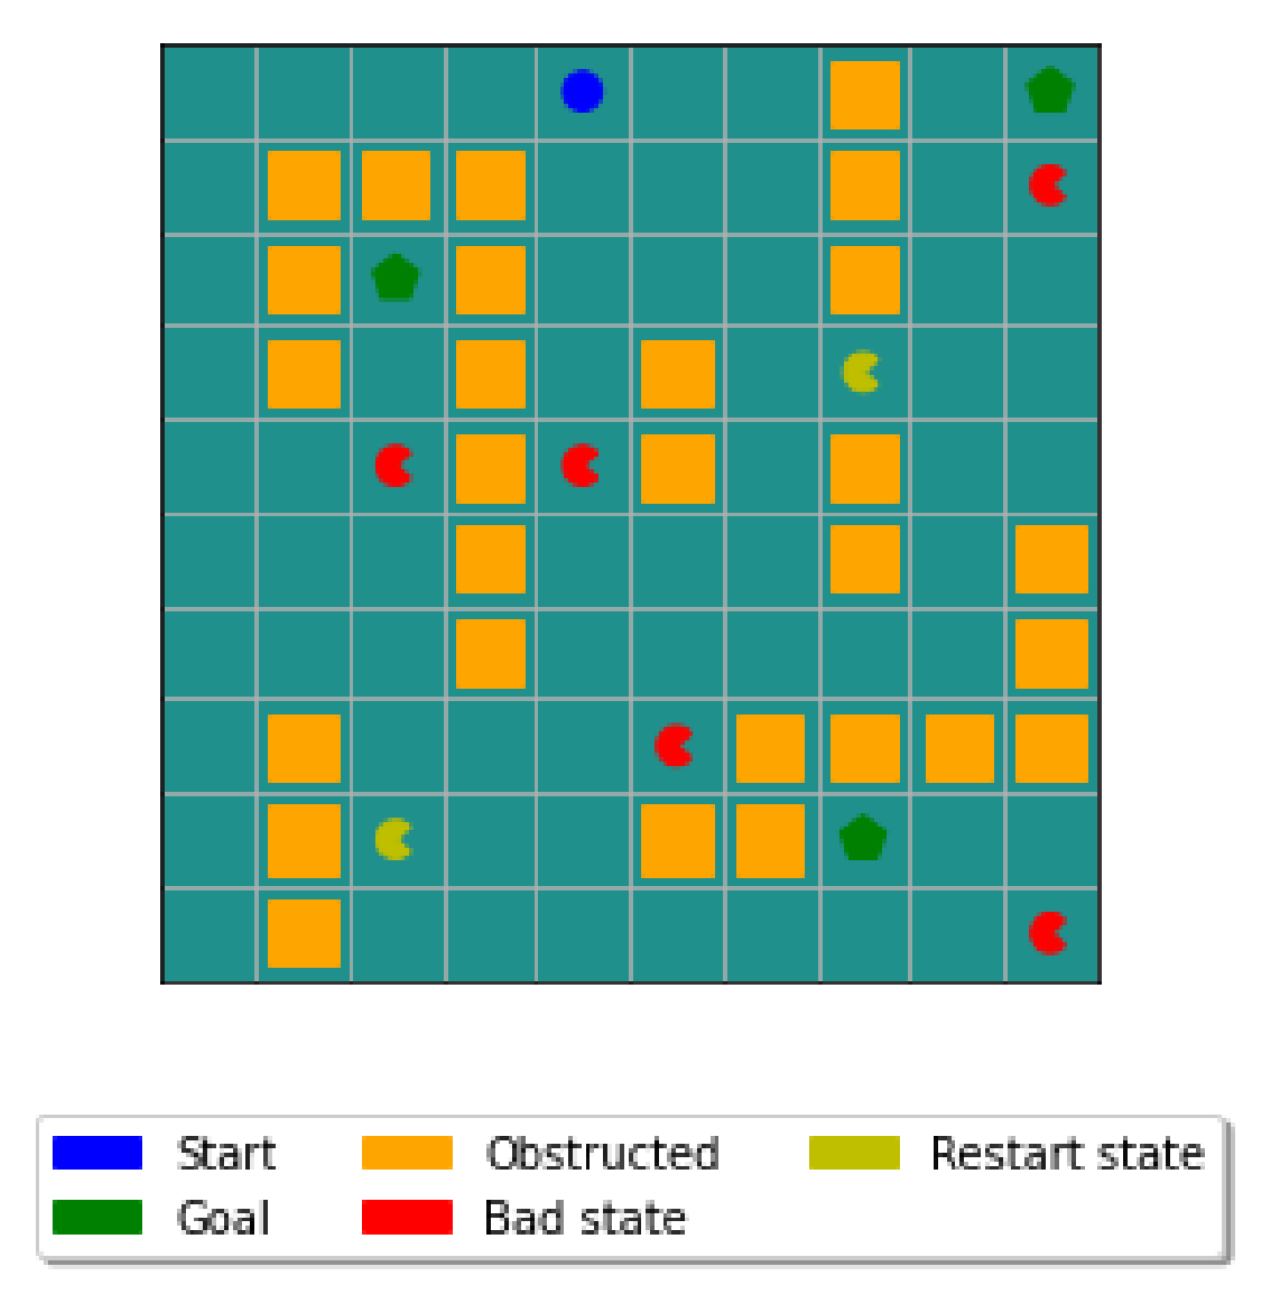

***Figure 1***

This is a grid world with 4 deterministic actions ('up', 'down', 'left', 'right'). The agent transitions to the next state determined by the direction of the action chosen with a probability of $p \in [0, 1]$. We also define a parameter called $b \in [0, 1]$ (Set $b=0.5$ for this assignment). Consider the direction of the action chosen as the agent's “North”. For example, if the action is 'left', it is the agent's North, and the agent's East would be the direction of the action 'up'. Figure 2 provides an illustration of the same. The agent transitions to the state West of the chosen action with probability $(1-p)\times b$, and to the East of the chosen action with probability $(1-p) \times (1-b)$.

 The environment may also have a wind blowing that can push the agent one **additional** cell to the right **after transitioning to the new state** with a probability of 0.4. An episode is terminated either when a goal is reached or when the timesteps exceed 100. Transitions that take you off the grid will not result in any change in state.

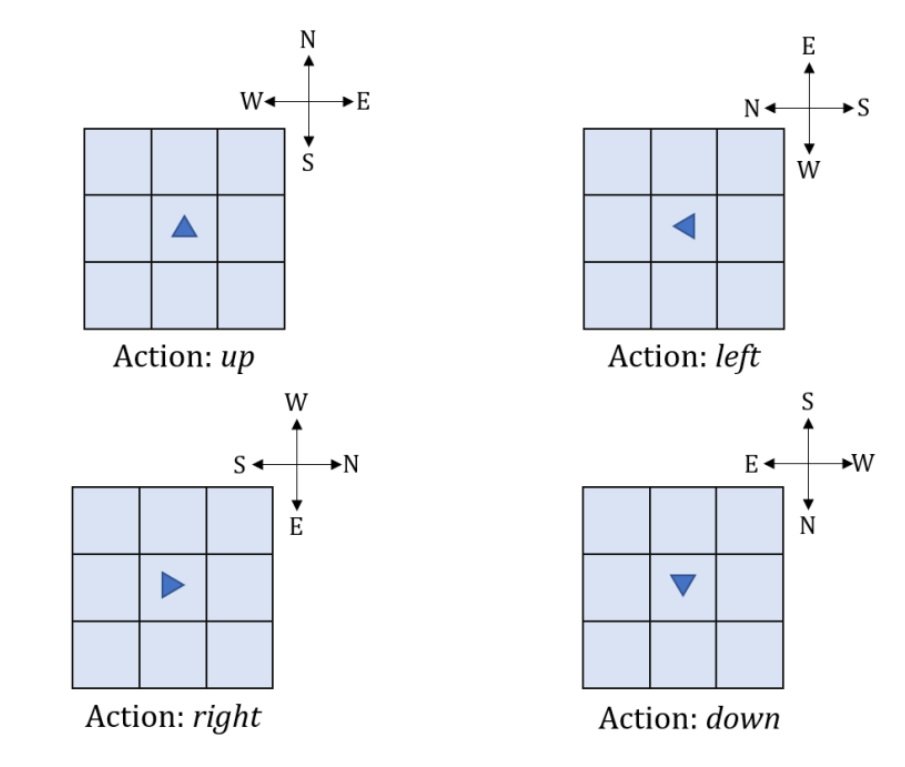

***Figure 2***

The dimensions of the grid are $10 \times 10$. The following types of states exist:

- ***Start state***: The agent starts from this state.
- ***Goal state***: The goal is to reach one of these states. There are 3 goal states in total.

- ***Obstructed state***: These are walls that prevent entry to the respective cells. Transition to these states will not result in any change.

- ***Bad state***: Entry into these states will incur a higher penalty than a normal state.
- ***Restart state***: Entry into these states will incur a very high penalty and will cause agent to teleport to the start state without the episode ending. Once the restart state is reached, no matter what action is chosen, it goes to the start state at the next step.
- ***Normal state***: None of the above. Entry into these states will incur a small penalty.


***Rewards***: -1 for normal states, -100 for restart states, -6 for bad states, +10 for goal states.

## Environment code

The code for the environment can be found below:

In [17]:
from math import floor
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

#Converts state number to row_column format
def row_col_to_seq(row_col, num_cols):
    return row_col[:,0] * num_cols + row_col[:,1]

#Converts row_column format to state number
def seq_to_col_row(seq, num_cols):
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1
        self.wind = wind

    # mark obstructed cells
    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):

                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1

        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]

    def visualize_gridworld(self):

        # create a 2D grid with empty cells
        grid_world_2D_array = np.ones((self.num_rows, self.num_cols))*ord("E")

        grid_world_2D_array[self.goal_states[:,0],self.goal_states[:,1]]= ord("G")
        grid_world_2D_array[self.obs_states[:,0],self.obs_states[:,1]]= ord("O")
        grid_world_2D_array[self.start_state[:,0],self.start_state[:,1]]= ord("S")
        grid_world_2D_array[self.bad_states[:,0],self.bad_states[:,1]]= ord("B")
        grid_world_2D_array[self.restart_states[:,0],self.restart_states[:,1]]= ord("R")

        grid_world_2D_array_colours = np.ones((self.num_rows, self.num_cols, 3))

        grid_world_2D_array_colours[grid_world_2D_array== ord("G")] =[0,1,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("O")] =[1,0.65,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("S")] =[0,0,1]
        grid_world_2D_array_colours[grid_world_2D_array== ord("B")] =[1,0,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("R")] =[1,1,0]

        fig = px.imshow(grid_world_2D_array_colours)

        state_label = np.empty_like(grid_world_2D_array,
                                    dtype ="<U10")

        state_label[grid_world_2D_array == ord("E")] ="Empty"
        state_label[grid_world_2D_array == ord("G")] ="Goal"
        state_label[grid_world_2D_array == ord("B")] ="Bad"
        state_label[grid_world_2D_array == ord("S")] ="Start"
        state_label[grid_world_2D_array == ord("R")] ="Restart"
        state_label[grid_world_2D_array == ord("O")] ="Obstacle"

        fig.update(data=[{'customdata': state_label,
                          'hovertemplate': 'x: %{x}<br>y: %{y}<br>State: %{customdata}'}])
        # add vertical and horizontal lines
        [fig.add_vline(x=i, line_width=2, line_dash="solid", line_color="Grey") for i in np.arange(-0.5,10)]
        [fig.add_hline(y=i, line_width=2, line_dash="solid", line_color="Grey") for i in np.arange(-0.5,10)]

        # ensure each row and column is numbered/labeled
        fig.update_layout(
            title ="Grid World Vizualization <br>Hover over to a cell for information",
            xaxis = dict(
                tickmode='linear',
                side='top',
                dtick=1),
            yaxis = dict(
                tickmode='linear',
                dtick=1)
        )
        fig.show()


## Environment instantiation

In [18]:
# specify world parameters

# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# starting position
start_state = np.array([[0,4]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

# create the environment's model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = False)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)
env = gw.create_gridworld()

## Visualize the grid world

In [19]:
# visualize the grid world configuration
env.visualize_gridworld()

## List environment variables

In [20]:
print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

Number of actions 4
Number of states 100
start state [4]
goal state(s) [ 9 22 87]


The $env.step()$ function takes as arguments the current state and action, and returns the reward and next state. The appropriate termination conditions have to be specified by the student in the code. $env.reset()$ resets the environment.

## Tasks
- Implement SARSA and Q-Learning.
- ~~For each algorithm, run experiments with wind=False and wind=True; two different start states: (0, 4), (3, 6); two values of $p$ (1.0, 0.7); and two types of exploration strategies ($\epsilon$-greedy and softmax), making it ***16 different configurations*** in total.~~
- For SARSA, there are a total of $8$ configurations:
  - set $p = 1$
  - wind could take one of two values, `True` or `False`
  - start state could take one of two values: `(0, 4)` or `(3, 6)`
  - exploration strategy could take one of two values: $\epsilon$-greedy or softmax
- For Q-learning, there are a total of $8$ configurations:
  - $p = 1$ or $p = 0.7$
  - set `wind = False`
  - start state could take one of two values: `(0, 4)` or `(3, 6)`
  - exploration strategy could take one of two values: $\epsilon$-greedy or softmax

- There are a total of $16$ configurations.
- For each of the $16$ configurations, determine the best set of hyperparameters (i.e. $ϵ$ in $ϵ$-greedy exploration, temperature $\beta$ in softmax exploration, learning rate $\alpha$, and discount factor $\gamma$) which maximize reward per episode over atleast 100 runs. Plot the following:
  1. Reward curves and the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).
  2. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.
  3. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.
- Try following set of values for each of the hyperparameters, for each of the configurations:

  a. learning rate ($α$) = [0.001, 0.01, 0.1, 1.0]

  b. discount factor ($γ$) = [0.7, 0.8, 0.9, 1.0]

  c. epsilon in $ϵ$-greedy = [0.001, 0.01, 0.05, 0.1] or
  
  Temperature in soft max ($τ$) = [0.01, 0.1, 1, 2]

For each of the algorithm, provide a written description of the policy learnt, explaining
the behavior of the agent, and your choice of hyperparameters. This description should
also provide information about how the behavior changes with and without the wind, for
different levels of stochasticity and for different start states.

The report can be organized in following manner:

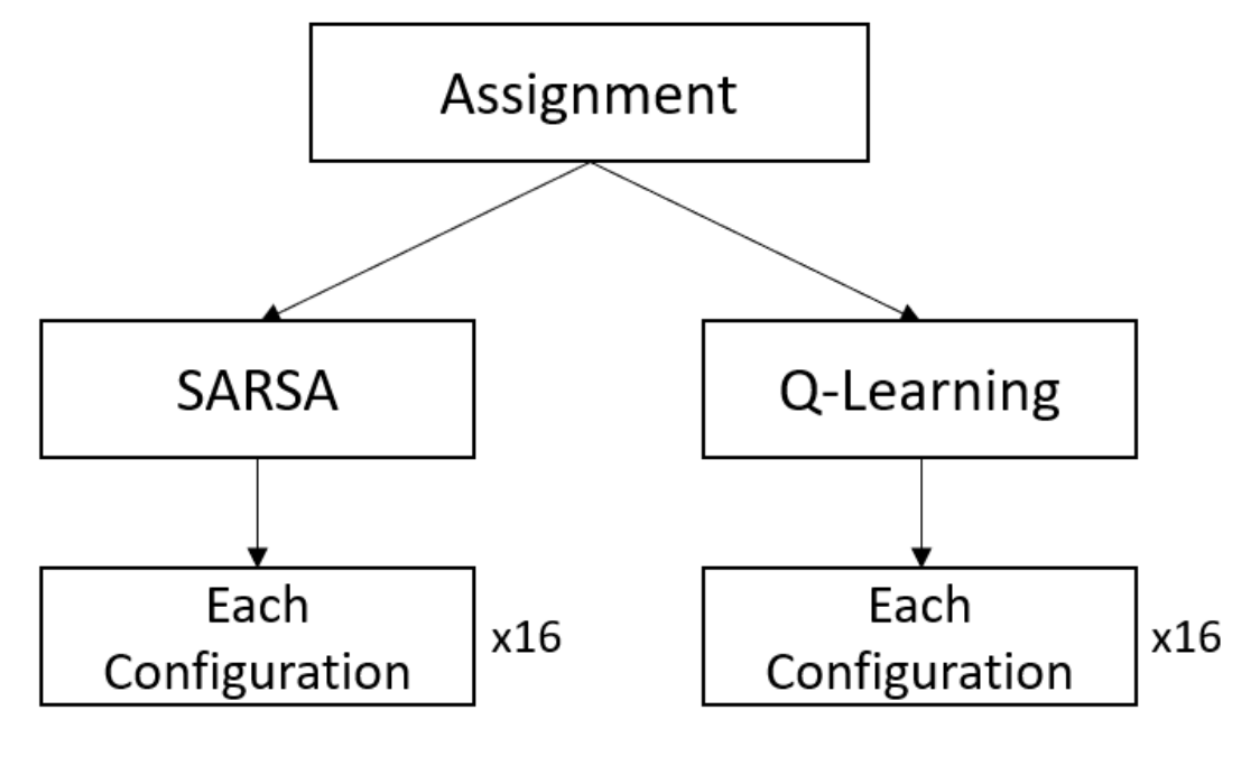

## Configurations [64 Marks]

There are total (~~32~~)16 configurations (~~16~~)8 each for SARSA and Q-Learning), each of which carry (~~2~~)4 marks.

Use below template for each of the configurations.

Hint: For reproducible results set random state appropriately.

## Hyperparameters

In [21]:
alphas = [0.001, 0.01, 0.1, 1.0]     # learning rates
gammas = [0.7, 0.8, 0.9, 1.0]     # discount factors
epsilons = [0.001, 0.01, 0.05, 0.1]    # epsilons
betas = [0.01, 0.1, 1, 2]     # temperatures

# Helper Classes and Functions

In [23]:
class MultiAgentRL:
    def __init__(self, env, alpha, gamma,
                 exploration_strategy="epsilon-greedy",
                 epsilon=0.1, # used only in "epsilon-greedy" exploration
                 temperature=0.01, # used only in "softmax" exploration
                 max_episodes=1000, max_steps=100, num_agents=50,
                 algorithm="SARSA", seed=42):
        self.env = env
        self.num_agents = num_agents
        self.alpha = alpha
        self.gamma = gamma
        self.max_steps = max_steps
        self.max_episodes = max_episodes
        self.epsilon = epsilon
        self.temperature = temperature
        self.exploration_strategy = exploration_strategy
        self.algorithm = algorithm
        self.q_table = np.zeros((env.num_states, env.num_actions))  # Common table for all agents so that agents can learn from each other
        self.rewards_per_episode = []
        self.steps_per_episode = []
        self.visit_counts = np.zeros((env.num_rows, env.num_cols))
        self.subtitle = f"p = {env.p_good_trans}, Wind = {env.wind}, Start State = {env.start_state[0]}, Exploration Strategy = {exploration_strategy},  α = {alpha}, γ={gamma}"

        if exploration_strategy == "softmax":
            self.subtitle += f", τ = {temperature}"
        elif exploration_strategy == "epsilon-greedy":
            self.subtitle += f", ϵ = {epsilon}"
        self.subtitle = f"<span style='font-size: 12px;'>{self.subtitle}</span>"

        if seed is not None:
            np.random.seed(seed)

    def reset(self):
        self.states = [self.env.reset() for _ in range(self.num_agents)]
        self.actions = [self.select_action(state) for state in self.states]

        # Increment visit counts for starting states
        for state in self.states:
            row_col = seq_to_col_row(state, self.env.num_cols)
            self.visit_counts[row_col[0,0], row_col[0,1]] += 1

    def softmax(self, x):
        e_x = np.exp((x - np.max(x)) / self.temperature)
        return e_x / e_x.sum(axis=0)

    def select_action(self, state):
        if self.exploration_strategy == "epsilon-greedy":
            if np.random.rand() < self.epsilon:
                return np.random.randint(self.env.num_actions)
            else:
                return np.argmax(self.q_table[state])
        elif self.exploration_strategy == "softmax":
            q_values = self.q_table[state]
            action_probs = self.softmax(q_values)
            return np.random.choice(np.arange(len(action_probs)), p=action_probs)

    def update(self, state, action, reward, next_state, next_action=None):
        current_q = self.q_table[state, action]
        if self.algorithm == "SARSA":
            next_q = self.q_table[next_state, next_action]
        elif self.algorithm == "Q-learning":
            next_q = np.max(self.q_table[next_state])

        target = reward + self.gamma * next_q
        self.q_table[state, action] += self.alpha * (target - current_q)

    def train(self):
        train_start = time.time()
        episodes_start = train_start
        for episode in range(self.max_episodes):
            self.reset()
            done = [False] * self.num_agents
            agents_steps = [0] * self.num_agents
            episode_steps = 0
            total_reward = 0

            while not all(done):
                for agent_idx in range(self.num_agents):
                    if done[agent_idx]:
                        continue

                    state = self.states[agent_idx]
                    action = self.actions[agent_idx]
                    next_state, reward = self.env.step(state, action)
                    next_action = self.select_action(next_state)

                    self.update(state, action, reward, next_state, next_action)

                    self.states[agent_idx] = next_state
                    self.actions[agent_idx] = next_action

                    row_col = seq_to_col_row(next_state, self.env.num_cols)
                    self.visit_counts[row_col[0,0], row_col[0,1]] += 1

                    total_reward += reward
                    agents_steps[agent_idx] += 1
                    episode_steps += 1
                    if next_state in self.env.goal_states_seq or agents_steps[agent_idx] >= self.max_steps:
                        done[agent_idx] = True

            self.rewards_per_episode.append(total_reward[0])
            self.steps_per_episode.append(episode_steps)

            print_frequency = round(self.max_episodes/5)
            if (episode + 1) % print_frequency == 0:
                print(f"Episodes {episode-print_frequency+2} to {episode + 1}/{self.max_episodes} completed in {round(time.time()-episodes_start, 2)}s")
                episodes_start = time.time()

        self.rewards_per_episode = np.array(self.rewards_per_episode) / self.num_agents
        self.steps_per_episode = np.array(self.steps_per_episode) / self.num_agents
        self.visit_counts = self.visit_counts / self.num_agents
        print(f"Training completed in {round(time.time()-train_start, 2)}s = {round((time.time()-train_start)/60, 2)}mins")

    def get_q_table(self):
        return self.q_table

    def plot_rewards(self):
        fig = go.Figure()
        fig.add_trace(go.Scatter(y=self.rewards_per_episode, mode='lines', name='Reward per Episode'))
        fig.update_layout(title=f'Reward per Episode ({self.algorithm})<br>{self.subtitle}', xaxis_title='Episode', yaxis_title='Total Reward')
        fig.show()

    def plot_steps_per_episode(self):
        fig = go.Figure()
        fig.add_trace(go.Scatter(y=self.steps_per_episode, mode='lines', name='Steps per Episode'))
        fig.update_layout(title=f'Steps per Episode ({self.algorithm})<br>{self.subtitle}', xaxis_title='Episode', yaxis_title='Number of Steps')
        fig.show()

    def plot_state_visit_counts(self):
        fig = px.imshow(self.visit_counts, color_continuous_scale='Viridis')
        fig.update_layout(title=f'State Visit Counts ({self.algorithm})<br>{self.subtitle}', xaxis_title='Column', yaxis_title='Row')
        fig.show()

    def plot_q_values(self):
        q_values = np.max(self.q_table, axis=1).reshape((self.env.num_rows, self.env.num_cols))
        actions = np.argmax(self.q_table, axis=1).reshape((self.env.num_rows, self.env.num_cols))

        action_map = {0: '↑', 1: '↓', 2: '←', 3: '→'}
        action_labels = np.vectorize(action_map.get)(actions)

        fig = sp.make_subplots(rows=1, cols=2, subplot_titles=('Optimal Actions', 'Q Values Heatmap'))



        fig.add_trace(
            go.Heatmap(z=self.visit_counts, colorscale='Viridis', showscale=False, opacity=0.3),
            row=1, col=1
        )

        # Update layout for actions
        for i in range(actions.shape[0]):
            for j in range(actions.shape[1]):
                if q_values[i, j] != 0:  # Only add Arrows where Q-values are non-zero
                    fig.add_annotation(
                        x=j, y=i,
                        text=action_labels[i, j],
                        showarrow=False,
                        font=dict(color="black", size=14),
                        xref="x1", yref="y1"  # Reference to the first subplot
                    )

        fig.add_trace(
            go.Heatmap(z=q_values, colorscale='Viridis', colorbar=dict(title='Q Values')),
            row=1, col=2
        )

        fig.update_layout(
            title=f'Q Values and Optimal Actions ({self.algorithm})<br>{self.subtitle}',
            height=600,
            # width=865,
            xaxis=dict(title='Column'),
            yaxis=dict(title='Row', autorange='reversed'),  # Ensure (0,0) is at top-left
            xaxis2=dict(title='Column'),
            yaxis2=dict(title='Row', autorange='reversed')  # Ensure (0,0) is at top-left
        )

        fig.show()




def tune_multi_agent_rl(env, alphas, gammas, epsilons=[], temperatures=[], max_episodes=1000, max_steps=100, num_agents=50,
                        exploration_strategy="epsilon-greedy", algorithm="SARSA", seed=42):
    best_reward = -float('inf')
    best_hyperparams = None
    results = []
    tune_count = 0
    tune_start = time.time()

    if exploration_strategy == "epsilon-greedy":
        for alpha, gamma, epsilon in itertools.product(alphas, gammas, epsilons):
            tune_count +=1
            print(f"Iter{tune_count}: Testing with α={alpha}, γ={gamma}, ϵ={epsilon}")
            agent = MultiAgentRL(env, alpha, gamma, exploration_strategy, epsilon, max_episodes=max_episodes, max_steps=max_steps, num_agents=num_agents, algorithm=algorithm, seed=seed)
            agent.train()

            avg_reward = np.mean(agent.rewards_per_episode)
            results.append((alpha, gamma, epsilon, avg_reward))

            if avg_reward > best_reward:
                best_reward = avg_reward
                best_hyperparams = (alpha, gamma, epsilon)
            print('--------------------------------------------------------------------')
        print(f"Best Hyperparameters: α={best_hyperparams[0]}, γ={best_hyperparams[1]}, ϵ={best_hyperparams[2]} with average reward {best_reward}")

    elif exploration_strategy == "softmax":
        for alpha, gamma, temperature in itertools.product(alphas, gammas, temperatures):
            tune_count +=1
            print(f"Iter{tune_count}: Testing with α={alpha}, γ={gamma}, τ={temperature}")
            agent = MultiAgentRL(env, alpha, gamma, exploration_strategy, temperature=temperature, max_episodes=max_episodes, max_steps=max_steps, num_agents=num_agents, algorithm=algorithm, seed=seed)
            agent.train()

            avg_reward = np.mean(agent.rewards_per_episode)
            results.append((alpha, gamma, temperature, avg_reward))

            if avg_reward > best_reward:
                best_reward = avg_reward
                best_hyperparams = (alpha, gamma, temperature)
            print('--------------------------------------------------------------------')
        print(f"Best Hyperparameters: α={best_hyperparams[0]}, γ={best_hyperparams[1]}, τ={best_hyperparams[2]} with average reward {best_reward}")

    print(f"Tuning completed in {round(time.time()-tune_start, 2)}s = {round((time.time()-tune_start)/60, 2)}mins")
    return best_hyperparams, results


### (1) Configuration id SARSA_true_0_4_p1_epsilon

#### Configuration Parameters
Learning algorithm = SARSA

Wind = True

Start State = (0, 4)

Value of $p$ = 1

Exploration strategy = ϵ-greedy

Train the agent

In [ ]:
# write your code here
gw.wind = True
gw.start_state =  np.array([[0,4]])
gw.add_transition_probability(p_good_transition=1, bias=0.5) # p
env = gw.create_gridworld()
exploration_strategy = "epsilon-greedy"

In [ ]:
best_hyperparams_SARSA_true_0_4_p1_epsilon, results_SARSA_true_0_4_p1_epsilon = tune_multi_agent_rl(env, alphas=alphas, gammas=gammas, exploration_strategy=exploration_strategy,
                             epsilons=epsilons, max_episodes=1000, max_steps=100, num_agents=50, algorithm="SARSA", seed=42)

Iter1: Testing with α=0.001, γ=0.7, ϵ=0.001


<ipython-input-6-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-64-267227258a2f>:58: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 200/1000 completed in 57.54s
Episodes 201 to 400/1000 completed in 29.17s
Episodes 401 to 600/1000 completed in 9.34s
Episodes 601 to 800/1000 completed in 7.82s
Episodes 801 to 1000/1000 completed in 6.87s
Training completed in 110.74s = 1.85mins
--------------------------------------------------------------------
Iter2: Testing with α=0.001, γ=0.7, ϵ=0.01
Episodes 1 to 200/1000 completed in 57.14s
Episodes 201 to 400/1000 completed in 29.12s
Episodes 401 to 600/1000 completed in 9.2s
Episodes 601 to 800/1000 completed in 7.86s
Episodes 801 to 1000/1000 completed in 8.04s
Training completed in 111.36s = 1.86mins
--------------------------------------------------------------------
Iter3: Testing with α=0.001, γ=0.7, ϵ=0.05
Episodes 1 to 200/1000 completed in 55.81s
Episodes 201 to 400/1000 completed in 32.5s
Episodes 401 to 600/1000 completed in 10.55s
Episodes 601 to 800/1000 completed in 8.15s
Episodes 801 to 1000/1000 completed in 8.84s
Training completed in 115.85s = 

In [ ]:
# (best_alpha, best_gamma, best_epsilon) = (0.1, 0.8, 0.001)
(best_alpha, best_gamma, best_epsilon) = best_hyperparams_SARSA_true_0_4_p1_epsilon
best_agent_SARSA_true_0_4_p1_epsilon = MultiAgentRL(env, alpha=best_alpha, gamma=best_gamma,
                                             exploration_strategy=exploration_strategy,
                                             epsilon=best_epsilon, max_episodes=1000, algorithm='SARSA', seed=42)
best_agent_SARSA_true_0_4_p1_epsilon.train()

<ipython-input-5-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-11-28694028ff48>:65: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 200/1000 completed in 9.83s
Episodes 201 to 400/1000 completed in 7.82s
Episodes 401 to 600/1000 completed in 7.62s
Episodes 601 to 800/1000 completed in 7.8s
Episodes 801 to 1000/1000 completed in 8.12s
Training completed in 41.19s = 0.69mins


1. Plot reward curves (during the training phase with the best hyperparameters).

In [ ]:
# write your code here
best_agent_SARSA_true_0_4_p1_epsilon.plot_rewards()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

In [ ]:
# write your code here
best_agent_SARSA_true_0_4_p1_epsilon.plot_steps_per_episode()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [ ]:
# write your code here
best_agent_SARSA_true_0_4_p1_epsilon.plot_state_visit_counts()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

In [ ]:
# write your code here
best_agent_SARSA_true_0_4_p1_epsilon.plot_q_values()

### (2) Configuration id SARSA_false_0_4_p1_epsilon

#### Configuration Parameters
Learning algorithm = SARSA

Wind = False

Start State = (0, 4)

Value of $p$ = 1

Exploration strategy = ϵ-greedy

Train the agent

In [ ]:
# write your code here
gw.wind = False
gw.start_state =  np.array([[0,4]])
gw.add_transition_probability(p_good_transition=1, bias=0.5) # p
env = gw.create_gridworld()
exploration_strategy = "epsilon-greedy"

In [ ]:
best_hyperparams_SARSA_false_0_4_p1_epsilon, results_SARSA_false_0_4_p1_epsilon = tune_multi_agent_rl(env, alphas=alphas, gammas=gammas, exploration_strategy=exploration_strategy,
                             epsilons=epsilons, max_episodes=1000, max_steps=100, num_agents=50, algorithm="SARSA", seed=42)

Iter1: Testing with α=0.001, γ=0.7, ϵ=0.001


<ipython-input-6-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-69-f53a05d86552>:58: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 200/1000 completed in 55.1s
Episodes 201 to 400/1000 completed in 35.0s
Episodes 401 to 600/1000 completed in 20.58s
Episodes 601 to 800/1000 completed in 13.94s
Episodes 801 to 1000/1000 completed in 11.53s
Training completed in 136.15s = 2.27mins
--------------------------------------------------------------------
Iter2: Testing with α=0.001, γ=0.7, ϵ=0.01
Episodes 1 to 200/1000 completed in 54.31s
Episodes 201 to 400/1000 completed in 33.85s
Episodes 401 to 600/1000 completed in 20.19s
Episodes 601 to 800/1000 completed in 14.55s
Episodes 801 to 1000/1000 completed in 12.87s
Training completed in 135.77s = 2.26mins
--------------------------------------------------------------------
Iter3: Testing with α=0.001, γ=0.7, ϵ=0.05
Episodes 1 to 200/1000 completed in 55.0s
Episodes 201 to 400/1000 completed in 42.11s
Episodes 401 to 600/1000 completed in 30.98s
Episodes 601 to 800/1000 completed in 20.14s
Episodes 801 to 1000/1000 completed in 18.56s
Training completed in 166

In [ ]:
(best_alpha, best_gamma, best_epsilon) = (0.1, 0.9, 0.05)
#  (best_alpha, best_gamma, best_epsilon) = best_hyperparams_SARSA_false_0_4_p1_epsilon

best_agent_SARSA_false_0_4_p1_epsilon = MultiAgentRL(env, alpha=best_alpha, gamma=best_gamma,
                                             exploration_strategy=exploration_strategy,
                                             epsilon=best_epsilon, max_episodes=1000, algorithm='SARSA', seed=42)
best_agent_SARSA_false_0_4_p1_epsilon.train()

<ipython-input-5-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-11-28694028ff48>:65: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 200/1000 completed in 7.38s
Episodes 201 to 400/1000 completed in 6.35s
Episodes 401 to 600/1000 completed in 5.49s
Episodes 601 to 800/1000 completed in 6.42s
Episodes 801 to 1000/1000 completed in 6.12s
Training completed in 31.75s = 0.53mins


1. Plot reward curves (during the training phase with the best hyperparameters).

In [ ]:
best_agent_SARSA_false_0_4_p1_epsilon.plot_rewards()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

In [ ]:
best_agent_SARSA_false_0_4_p1_epsilon.plot_steps_per_episode()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [ ]:
best_agent_SARSA_false_0_4_p1_epsilon.plot_state_visit_counts()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

In [ ]:
best_agent_SARSA_false_0_4_p1_epsilon.plot_q_values()

### (3) Configuration id SARSA_true_3_6_p1_epsilon

#### Configuration Parameters
Learning algorithm = SARSA

Wind = True

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = ϵ-greedy

Train the agent

In [ ]:
# write your code here
gw.wind = True
gw.start_state =  np.array([[3,6]])
gw.add_transition_probability(p_good_transition=1, bias=0.5) # p
env = gw.create_gridworld()
exploration_strategy = "epsilon-greedy"

best_hyperparams_SARSA_true_3_6_p1_epsilon, results_SARSA_true_3_6_p1_epsilon = tune_multi_agent_rl(env, alphas=alphas, gammas=gammas, exploration_strategy=exploration_strategy,
                             epsilons=epsilons, max_episodes=1000, max_steps=100, num_agents=50, algorithm="SARSA", seed=42)

Iter1: Testing with α=0.001, γ=0.7, ϵ=0.001


<ipython-input-3-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-9-f53a05d86552>:58: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 200/1000 completed in 50.75s
Episodes 201 to 400/1000 completed in 21.4s
Episodes 401 to 600/1000 completed in 8.62s
Episodes 601 to 800/1000 completed in 8.15s
Episodes 801 to 1000/1000 completed in 7.85s
Training completed in 96.78s = 1.61mins
--------------------------------------------------------------------
Iter2: Testing with α=0.001, γ=0.7, ϵ=0.01
Episodes 1 to 200/1000 completed in 50.41s
Episodes 201 to 400/1000 completed in 22.65s
Episodes 401 to 600/1000 completed in 8.38s
Episodes 601 to 800/1000 completed in 8.59s
Episodes 801 to 1000/1000 completed in 9.16s
Training completed in 99.2s = 1.65mins
--------------------------------------------------------------------
Iter3: Testing with α=0.001, γ=0.7, ϵ=0.05
Episodes 1 to 200/1000 completed in 52.2s
Episodes 201 to 400/1000 completed in 23.55s
Episodes 401 to 600/1000 completed in 12.32s
Episodes 601 to 800/1000 completed in 9.33s
Episodes 801 to 1000/1000 completed in 26.93s
Training completed in 124.34s = 2.

In [ ]:
(best_alpha, best_gamma, best_epsilon) = best_hyperparams_SARSA_true_3_6_p1_epsilon

best_agent_SARSA_true_3_6_p1_epsilon = MultiAgentRL(env, alpha=best_alpha, gamma=best_gamma,
                                             exploration_strategy=exploration_strategy,
                                             epsilon=best_epsilon, max_episodes=1000, algorithm='SARSA', seed=42)
best_agent_SARSA_true_3_6_p1_epsilon.train()

<ipython-input-3-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-64-2f4d60b32d7d>:58: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 200/1000 completed in 9.54s
Episodes 201 to 400/1000 completed in 9.05s
Episodes 401 to 600/1000 completed in 8.53s
Episodes 601 to 800/1000 completed in 8.65s
Episodes 801 to 1000/1000 completed in 8.54s
Training completed in 44.31s = 0.74mins


1. Plot reward curves (during the training phase with the best hyperparameters).

In [ ]:
best_agent_SARSA_true_3_6_p1_epsilon.plot_rewards()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

In [ ]:
best_agent_SARSA_true_3_6_p1_epsilon.plot_steps_per_episode()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [ ]:
best_agent_SARSA_true_3_6_p1_epsilon.plot_state_visit_counts()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

In [ ]:
best_agent_SARSA_true_3_6_p1_epsilon.plot_q_values()

### (4) Configuration id SARSA_false_3_6_p1_epsilon

#### Configuration Parameters
Learning algorithm = SARSA

Wind = False

Start State = (3, 6)

Value of $p$ = 1

Exploration strategy = ϵ-greedy

Train the agent

In [ ]:
# write your code here
gw.wind = False
gw.start_state =  np.array([[3,6]])
gw.add_transition_probability(p_good_transition=1, bias=0.5) # p
env = gw.create_gridworld()
exploration_strategy = "epsilon-greedy"

best_hyperparams_SARSA_false_3_6_p1_epsilon, results_SARSA_false_3_6_p1_epsilon = tune_multi_agent_rl(env, alphas=alphas, gammas=gammas, exploration_strategy=exploration_strategy,
                             epsilons=epsilons, max_episodes=1000, max_steps=100, num_agents=50, algorithm="SARSA", seed=42)

Iter1: Testing with α=0.001, γ=0.7, ϵ=0.001


<ipython-input-3-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-64-2f4d60b32d7d>:58: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 200/1000 completed in 73.25s
Episodes 201 to 400/1000 completed in 25.86s
Episodes 401 to 600/1000 completed in 12.22s
Episodes 601 to 800/1000 completed in 10.75s
Episodes 801 to 1000/1000 completed in 11.52s
Training completed in 133.6s = 2.23mins
--------------------------------------------------------------------
Iter2: Testing with α=0.001, γ=0.7, ϵ=0.01
Episodes 1 to 200/1000 completed in 55.08s
Episodes 201 to 400/1000 completed in 25.93s
Episodes 401 to 600/1000 completed in 12.35s
Episodes 601 to 800/1000 completed in 10.57s
Episodes 801 to 1000/1000 completed in 10.77s
Training completed in 114.7s = 1.91mins
--------------------------------------------------------------------
Iter3: Testing with α=0.001, γ=0.7, ϵ=0.05
Episodes 1 to 200/1000 completed in 57.33s
Episodes 201 to 400/1000 completed in 25.07s
Episodes 401 to 600/1000 completed in 13.72s
Episodes 601 to 800/1000 completed in 12.09s
Episodes 801 to 1000/1000 completed in 11.64s
Training completed in 11

In [ ]:
(best_alpha, best_gamma, best_epsilon) = best_hyperparams_SARSA_false_3_6_p1_epsilon

best_agent_SARSA_false_3_6_p1_epsilon = MultiAgentRL(env, alpha=best_alpha, gamma=best_gamma,
                                             exploration_strategy=exploration_strategy,
                                             epsilon=best_epsilon, max_episodes=1000, algorithm='SARSA', seed=42)
best_agent_SARSA_false_3_6_p1_epsilon.train()

<ipython-input-3-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-64-2f4d60b32d7d>:58: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 200/1000 completed in 12.7s
Episodes 201 to 400/1000 completed in 11.3s
Episodes 401 to 600/1000 completed in 11.42s
Episodes 601 to 800/1000 completed in 11.99s
Episodes 801 to 1000/1000 completed in 11.32s
Training completed in 58.73s = 0.98mins


1. Plot reward curves (during the training phase with the best hyperparameters).

In [ ]:
best_agent_SARSA_false_3_6_p1_epsilon.plot_rewards()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

In [ ]:
best_agent_SARSA_false_3_6_p1_epsilon.plot_steps_per_episode()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [ ]:
best_agent_SARSA_false_3_6_p1_epsilon.plot_state_visit_counts()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

In [ ]:
best_agent_SARSA_false_3_6_p1_epsilon.plot_q_values()

### (5) Configuration id SARSA_true_0_4_p1_softmax

#### Configuration Parameters
Learning algorithm = SARSA

Wind =True

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = Softmax

Train the agent

In [ ]:
# write your code here
gw.wind = True
gw.start_state =  np.array([[0,4]])
gw.add_transition_probability(p_good_transition=1, bias=0.5) # p
env = gw.create_gridworld()
exploration_strategy = "softmax"

best_hyperparams_SARSA_true_0_4_p1_softmax, results_SARSA_true_0_4_p1_softmax = tune_multi_agent_rl(
    env, alphas=alphas, gammas=gammas, exploration_strategy=exploration_strategy, temperatures=betas, max_episodes=1000,
    max_steps=100, num_agents=50, algorithm="SARSA", seed=42)

Iter1: Testing with α=0.001, γ=0.7, τ=0.01


<ipython-input-3-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-81-e86b998b837e>:61: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 200/1000 completed in 117.45s
Episodes 201 to 400/1000 completed in 82.84s
Episodes 401 to 600/1000 completed in 52.92s
Episodes 601 to 800/1000 completed in 28.96s
Episodes 801 to 1000/1000 completed in 24.39s
Training completed in 306.56s = 5.11mins
--------------------------------------------------------------------
Iter2: Testing with α=0.001, γ=0.7, τ=0.1
Episodes 1 to 200/1000 completed in 122.4s
Episodes 201 to 400/1000 completed in 122.07s
Episodes 401 to 600/1000 completed in 124.45s
Episodes 601 to 800/1000 completed in 121.85s
Episodes 801 to 1000/1000 completed in 124.33s
Training completed in 615.1s = 10.25mins
--------------------------------------------------------------------
Iter3: Testing with α=0.001, γ=0.7, τ=1
Episodes 1 to 200/1000 completed in 149.06s
Episodes 201 to 400/1000 completed in 126.95s
Episodes 401 to 600/1000 completed in 125.45s
Episodes 601 to 800/1000 completed in 126.36s
Episodes 801 to 1000/1000 completed in 124.91s
Training complet

In [ ]:
(best_alpha, best_gamma, best_temperature) = (0.1, 1.0, 0.1)
# (best_alpha, best_gamma, best_temperature) = best_hyperparams_SARSA_true_0_4_p1_softmax
exploration_strategy = "softmax"

best_agent_SARSA_true_0_4_p1_softmax = MultiAgentRL(
    env, alpha=best_alpha, gamma=best_gamma, exploration_strategy=exploration_strategy, temperature=best_temperature,
    max_episodes=1000, algorithm='SARSA', seed=42)
best_agent_SARSA_true_0_4_p1_softmax.train()

<ipython-input-5-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-10-e70d8cb8e926>:63: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 200/1000 completed in 21.34s
Episodes 201 to 400/1000 completed in 19.63s
Episodes 401 to 600/1000 completed in 18.88s
Episodes 601 to 800/1000 completed in 20.14s
Episodes 801 to 1000/1000 completed in 20.12s
Training completed in 100.12s = 1.67mins


1. Plot reward curves (during the training phase with the best hyperparameters).

In [ ]:
best_agent_SARSA_true_0_4_p1_softmax.plot_rewards()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

In [ ]:
best_agent_SARSA_true_0_4_p1_softmax.plot_steps_per_episode()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [ ]:
best_agent_SARSA_true_0_4_p1_softmax.plot_state_visit_counts()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

In [ ]:
best_agent_SARSA_true_0_4_p1_softmax.plot_q_values()

### (6) Configuration id SARSA_false_0_4_p1_softmax

#### Configuration Parameters
Learning algorithm = SARSA

Wind = False

Start State = (0, 4)

Value of $p$ = 1

Exploration strategy = softmax

Train the agent

In [ ]:
# write your code here
gw.wind = False
gw.start_state =  np.array([[0,4]])
gw.add_transition_probability(p_good_transition=1, bias=0.5) # p
env = gw.create_gridworld()
exploration_strategy = "softmax"

In [ ]:
best_hyperparams_SARSA_false_0_4_p1_softmax, results_SARSA_false_0_4_p1_softmax = tune_multi_agent_rl(
    env, alphas=alphas, gammas=gammas, exploration_strategy=exploration_strategy,
    temperatures=betas, max_episodes=1000, max_steps=100, num_agents=50, algorithm="SARSA", seed=42)

Iter1: Testing with α=0.001, γ=0.7, τ=0.01


<ipython-input-5-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-28-712d5d3e0432>:61: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 200/1000 completed in 96.96s
Episodes 201 to 400/1000 completed in 60.03s
Episodes 401 to 600/1000 completed in 40.03s
Episodes 601 to 800/1000 completed in 27.47s
Episodes 801 to 1000/1000 completed in 23.05s
Training completed in 247.55s = 4.13mins
--------------------------------------------------------------------
Iter2: Testing with α=0.001, γ=0.7, τ=0.1
Episodes 1 to 200/1000 completed in 99.89s
Episodes 201 to 400/1000 completed in 81.25s
Episodes 401 to 600/1000 completed in 71.71s
Episodes 601 to 800/1000 completed in 68.48s
Episodes 801 to 1000/1000 completed in 60.17s
Training completed in 381.5s = 6.36mins
--------------------------------------------------------------------
Iter3: Testing with α=0.001, γ=0.7, τ=1
Episodes 1 to 200/1000 completed in 102.78s
Episodes 201 to 400/1000 completed in 102.29s
Episodes 401 to 600/1000 completed in 101.27s
Episodes 601 to 800/1000 completed in 100.66s
Episodes 801 to 1000/1000 completed in 99.49s
Training completed in 5

In [ ]:
(best_alpha, best_gamma, best_temperature) = (1.0, 0.8, 0.01)
# (best_alpha, best_gamma, best_temperature) = best_hyperparams_SARSA_false_0_4_p1_softmax

best_agent_SARSA_false_0_4_p1_softmax = MultiAgentRL(
    env, alpha=best_alpha, gamma=best_gamma, exploration_strategy=exploration_strategy,
    temperature=best_temperature, max_episodes=1000, algorithm='SARSA', seed=42)
best_agent_SARSA_false_0_4_p1_softmax.train()

<ipython-input-4-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-9-28694028ff48>:65: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 200/1000 completed in 20.42s
Episodes 201 to 400/1000 completed in 21.66s
Episodes 401 to 600/1000 completed in 21.22s
Episodes 601 to 800/1000 completed in 20.25s
Episodes 801 to 1000/1000 completed in 20.58s
Training completed in 104.12s = 1.74mins


1. Plot reward curves (during the training phase with the best hyperparameters).

In [ ]:
best_agent_SARSA_false_0_4_p1_softmax.plot_rewards()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

In [ ]:
best_agent_SARSA_false_0_4_p1_softmax.plot_steps_per_episode()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [ ]:
best_agent_SARSA_false_0_4_p1_softmax.plot_state_visit_counts()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

In [ ]:
best_agent_SARSA_false_0_4_p1_softmax.plot_q_values()

### (7) Configuration id SARSA_true_3_6_p1_softmax

#### Configuration Parameters
Learning algorithm = SARSA

Wind = True

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = Softmax

Train the agent

In [ ]:
# write your code here
gw.wind = True
gw.start_state =  np.array([[3,6]])
gw.add_transition_probability(p_good_transition=1, bias=0.5) # p
env = gw.create_gridworld()
exploration_strategy = "softmax"

In [ ]:

best_hyperparams_SARSA_true_3_6_p1_softmax, results_SARSA_true_3_6_p1_softmax = tune_multi_agent_rl(
    env, alphas=alphas, gammas=gammas, exploration_strategy=exploration_strategy,
    temperatures=betas, max_episodes=200, max_steps=100, num_agents=50, algorithm="SARSA", seed=42)

Iter1: Testing with α=0.001, γ=0.7, τ=0.01


<ipython-input-2-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-10-22832aebfd8f>:65: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 40/200 completed in 18.46s
Episodes 41 to 80/200 completed in 19.28s
Episodes 81 to 120/200 completed in 15.38s
Episodes 121 to 160/200 completed in 12.31s
Episodes 161 to 200/200 completed in 11.28s
Training completed in 76.71s = 1.28mins
--------------------------------------------------------------------
Iter2: Testing with α=0.001, γ=0.7, τ=0.1
Episodes 1 to 40/200 completed in 20.77s
Episodes 41 to 80/200 completed in 17.93s
Episodes 81 to 120/200 completed in 15.64s
Episodes 121 to 160/200 completed in 13.63s
Episodes 161 to 200/200 completed in 12.23s
Training completed in 80.2s = 1.34mins
--------------------------------------------------------------------
Iter3: Testing with α=0.001, γ=0.7, τ=1
Episodes 1 to 40/200 completed in 18.92s
Episodes 41 to 80/200 completed in 18.2s
Episodes 81 to 120/200 completed in 18.93s
Episodes 121 to 160/200 completed in 16.88s
Episodes 161 to 200/200 completed in 15.81s
Training completed in 88.73s = 1.48mins
--------------------

In [ ]:
(best_alpha, best_gamma, best_temperature) = best_hyperparams_SARSA_true_3_6_p1_softmax

best_agent_SARSA_true_3_6_p1_softmax = MultiAgentRL(
    env, alpha=best_alpha, gamma=best_gamma, exploration_strategy=exploration_strategy,
    temperature=best_temperature, max_episodes=1000, algorithm='SARSA', seed=42)
best_agent_SARSA_true_3_6_p1_softmax.train()

<ipython-input-2-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-18-28694028ff48>:65: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 200/1000 completed in 15.2s
Episodes 201 to 400/1000 completed in 14.54s
Episodes 401 to 600/1000 completed in 14.54s
Episodes 601 to 800/1000 completed in 14.85s
Episodes 801 to 1000/1000 completed in 16.59s
Training completed in 75.72s = 1.26mins


1. Plot reward curves (during the training phase with the best hyperparameters).

In [ ]:
best_agent_SARSA_true_3_6_p1_softmax.plot_rewards()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

In [ ]:
best_agent_SARSA_true_3_6_p1_softmax.plot_steps_per_episode()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [ ]:
best_agent_SARSA_true_3_6_p1_softmax.plot_state_visit_counts()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

In [ ]:
best_agent_SARSA_true_3_6_p1_softmax.plot_q_values()

### (8) Configuration id SARSA_false_3_6_p1_softmax

#### Configuration Parameters
Learning algorithm = SARSA

Wind = False

Start State = (3, 6)

Value of $p$ = 1

Exploration strategy = softmax

Train the agent

In [ ]:
# write your code here
gw.wind = False
gw.start_state =  np.array([[3,6]])
gw.add_transition_probability(p_good_transition=1, bias=0.5) # p
env = gw.create_gridworld()
exploration_strategy = "softmax"

best_hyperparams_SARSA_false_3_6_p1_softmax, results_SARSA_false_3_6_p1_softmax = tune_multi_agent_rl(
    env, alphas=alphas, gammas=gammas, exploration_strategy=exploration_strategy,
    temperatures=betas, max_episodes=200, max_steps=100, num_agents=50, algorithm="SARSA", seed=42)

Iter1: Testing with α=0.001, γ=0.7, τ=0.01


<ipython-input-2-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-18-28694028ff48>:65: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 40/200 completed in 20.3s
Episodes 41 to 80/200 completed in 17.44s
Episodes 81 to 120/200 completed in 15.51s
Episodes 121 to 160/200 completed in 13.75s
Episodes 161 to 200/200 completed in 12.39s
Training completed in 79.39s = 1.32mins
--------------------------------------------------------------------
Iter2: Testing with α=0.001, γ=0.7, τ=0.1
Episodes 1 to 40/200 completed in 20.49s
Episodes 41 to 80/200 completed in 18.67s
Episodes 81 to 120/200 completed in 19.12s
Episodes 121 to 160/200 completed in 15.89s
Episodes 161 to 200/200 completed in 14.69s
Training completed in 88.86s = 1.48mins
--------------------------------------------------------------------
Iter3: Testing with α=0.001, γ=0.7, τ=1
Episodes 1 to 40/200 completed in 22.42s
Episodes 41 to 80/200 completed in 21.51s
Episodes 81 to 120/200 completed in 19.12s
Episodes 121 to 160/200 completed in 19.77s
Episodes 161 to 200/200 completed in 18.45s
Training completed in 101.28s = 1.69mins
------------------

In [ ]:
(best_alpha, best_gamma, best_temperature) = best_hyperparams_SARSA_false_3_6_p1_softmax

best_agent_SARSA_false_3_6_p1_softmax = MultiAgentRL(
    env, alpha=best_alpha, gamma=best_gamma, exploration_strategy=exploration_strategy,
    temperature=best_temperature, max_episodes=1000, algorithm='SARSA', seed=42)
best_agent_SARSA_false_3_6_p1_softmax.train()

<ipython-input-2-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-18-28694028ff48>:65: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 200/1000 completed in 14.77s
Episodes 201 to 400/1000 completed in 14.43s
Episodes 401 to 600/1000 completed in 14.34s
Episodes 601 to 800/1000 completed in 14.02s
Episodes 801 to 1000/1000 completed in 15.32s
Training completed in 72.88s = 1.21mins


1. Plot reward curves (during the training phase with the best hyperparameters).

In [ ]:
best_agent_SARSA_false_3_6_p1_softmax.plot_rewards()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

In [ ]:
best_agent_SARSA_false_3_6_p1_softmax.plot_steps_per_episode()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [ ]:
best_agent_SARSA_false_3_6_p1_softmax.plot_state_visit_counts()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

In [ ]:
best_agent_SARSA_false_3_6_p1_softmax.plot_q_values()

### (9) Configuration id QL_false_0_4_p1_epsilon

#### Configuration Parameters
Learning algorithm = Q-learning

Wind = False

Start State = (0,4)

Value of $p$ = $1$

Exploration strategy =  ϵ-greedy

Train the agent

In [ ]:
# write your code here
gw.wind = False
gw.start_state =  np.array([[0,4]])
gw.add_transition_probability(p_good_transition=1, bias=0.5) # p
env = gw.create_gridworld()
exploration_strategy = "epsilon-greedy"

best_hyperparams_QL_false_0_4_p1_epsilon, results_QL_false_0_4_p1_epsilon = tune_multi_agent_rl(
    env, alphas=alphas, gammas=gammas, exploration_strategy=exploration_strategy, epsilons=epsilons,
    max_episodes=1000, max_steps=100, num_agents=50, algorithm="Q-learning", seed=42)

Iter1: Testing with α=0.001, γ=0.7, ϵ=0.001


<ipython-input-2-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-18-28694028ff48>:65: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 200/1000 completed in 66.77s
Episodes 201 to 400/1000 completed in 39.17s
Episodes 401 to 600/1000 completed in 23.28s
Episodes 601 to 800/1000 completed in 15.83s
Episodes 801 to 1000/1000 completed in 14.04s
Training completed in 159.1s = 2.65mins
--------------------------------------------------------------------
Iter2: Testing with α=0.001, γ=0.7, ϵ=0.01
Episodes 1 to 200/1000 completed in 66.15s
Episodes 201 to 400/1000 completed in 39.47s
Episodes 401 to 600/1000 completed in 23.57s
Episodes 601 to 800/1000 completed in 16.5s
Episodes 801 to 1000/1000 completed in 14.3s
Training completed in 160.0s = 2.67mins
--------------------------------------------------------------------
Iter3: Testing with α=0.001, γ=0.7, ϵ=0.05
Episodes 1 to 200/1000 completed in 64.99s
Episodes 201 to 400/1000 completed in 40.02s
Episodes 401 to 600/1000 completed in 23.58s
Episodes 601 to 800/1000 completed in 16.56s
Episodes 801 to 1000/1000 completed in 14.78s
Training completed in 159.

In [ ]:
(best_alpha, best_gamma, best_epsilon) = best_hyperparams_QL_false_0_4_p1_epsilon

best_agent_QL_false_0_4_p1_epsilon = MultiAgentRL(
    env, alpha=best_alpha, gamma=best_gamma, exploration_strategy=exploration_strategy,
    epsilon=best_epsilon, max_episodes=1000, algorithm='Q-learning', seed=42)
best_agent_QL_false_0_4_p1_epsilon.train()

<ipython-input-2-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-18-28694028ff48>:65: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 200/1000 completed in 15.1s
Episodes 201 to 400/1000 completed in 15.02s
Episodes 401 to 600/1000 completed in 14.28s
Episodes 601 to 800/1000 completed in 14.24s
Episodes 801 to 1000/1000 completed in 14.15s
Training completed in 72.79s = 1.21mins


1. Plot reward curves (during the training phase with the best hyperparameters).

In [ ]:
best_agent_QL_false_0_4_p1_epsilon.plot_rewards()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

In [ ]:
best_agent_QL_false_0_4_p1_epsilon.plot_steps_per_episode()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [ ]:
best_agent_QL_false_0_4_p1_epsilon.plot_state_visit_counts()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

In [ ]:
best_agent_QL_false_0_4_p1_epsilon.plot_q_values()

### (10) Configuration id QL_false_3_6_p1_epsilon

#### Configuration Parameters
Learning algorithm = Q-learning

Wind = False

Start State = (3,6)

Value of $p$ = $1$

Exploration strategy =  ϵ-greedy

Train the agent

In [ ]:
# write your code here
gw.wind = False
gw.start_state =  np.array([[3,6]])
gw.add_transition_probability(p_good_transition=1, bias=0.5) # p
env = gw.create_gridworld()
exploration_strategy = "epsilon-greedy"

best_hyperparams_QL_false_3_6_p1_epsilon, results_QL_false_3_6_p1_epsilon = tune_multi_agent_rl(
    env, alphas=alphas, gammas=gammas, exploration_strategy=exploration_strategy, epsilons=epsilons,
    max_episodes=1000, max_steps=100, num_agents=50, algorithm="Q-learning", seed=42)

Iter1: Testing with α=0.001, γ=0.7, ϵ=0.001


<ipython-input-2-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-18-28694028ff48>:65: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 200/1000 completed in 59.3s
Episodes 201 to 400/1000 completed in 25.9s
Episodes 401 to 600/1000 completed in 11.92s
Episodes 601 to 800/1000 completed in 10.56s
Episodes 801 to 1000/1000 completed in 10.86s
Training completed in 118.54s = 1.98mins
--------------------------------------------------------------------
Iter2: Testing with α=0.001, γ=0.7, ϵ=0.01
Episodes 1 to 200/1000 completed in 58.28s
Episodes 201 to 400/1000 completed in 26.27s
Episodes 401 to 600/1000 completed in 12.6s
Episodes 601 to 800/1000 completed in 10.87s
Episodes 801 to 1000/1000 completed in 10.9s
Training completed in 118.93s = 1.98mins
--------------------------------------------------------------------
Iter3: Testing with α=0.001, γ=0.7, ϵ=0.05
Episodes 1 to 200/1000 completed in 58.59s
Episodes 201 to 400/1000 completed in 27.3s
Episodes 401 to 600/1000 completed in 13.1s
Episodes 601 to 800/1000 completed in 12.7s
Episodes 801 to 1000/1000 completed in 11.71s
Training completed in 123.41s

In [ ]:
(best_alpha, best_gamma, best_epsilon) = best_hyperparams_QL_false_3_6_p1_epsilon

best_agent_QL_false_3_6_p1_epsilon = MultiAgentRL(
    env, alpha=best_alpha, gamma=best_gamma, exploration_strategy=exploration_strategy,
    epsilon=best_epsilon, max_episodes=1000, algorithm='Q-learning', seed=42)
best_agent_QL_false_3_6_p1_epsilon.train()

<ipython-input-2-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-18-28694028ff48>:65: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 200/1000 completed in 12.34s
Episodes 201 to 400/1000 completed in 11.39s
Episodes 401 to 600/1000 completed in 11.07s
Episodes 601 to 800/1000 completed in 11.39s
Episodes 801 to 1000/1000 completed in 11.11s
Training completed in 57.3s = 0.96mins


1. Plot reward curves (during the training phase with the best hyperparameters).

In [ ]:
best_agent_QL_false_3_6_p1_epsilon.plot_rewards()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

In [ ]:
best_agent_QL_false_3_6_p1_epsilon.plot_steps_per_episode()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [ ]:
best_agent_QL_false_3_6_p1_epsilon.plot_state_visit_counts()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

In [ ]:
best_agent_QL_false_3_6_p1_epsilon.plot_q_values()

### (11) Configuration id QL_false_0_4_p_0_7_epsilon

#### Configuration Parameters
Learning algorithm = Q-learning

Wind = False

Start State = (0,4)

Value of $p$ = $0.7$

Exploration strategy =  ϵ-greedy

Train the agent

In [ ]:
# write your code here
gw.wind = False
gw.start_state =  np.array([[0,4]])
gw.add_transition_probability(p_good_transition=0.7, bias=0.5) # p
env = gw.create_gridworld()
exploration_strategy = "epsilon-greedy"

best_hyperparams_QL_false_0_4_p_0_7_epsilon, results_QL_false_0_4_p_0_7_epsilon = tune_multi_agent_rl(
    env, alphas=alphas, gammas=gammas, exploration_strategy=exploration_strategy, epsilons=epsilons,
    max_episodes=1000, max_steps=100, num_agents=50, algorithm="Q-learning", seed=42)

Iter1: Testing with α=0.001, γ=0.7, ϵ=0.001


<ipython-input-2-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-7-28694028ff48>:65: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 200/1000 completed in 82.08s
Episodes 201 to 400/1000 completed in 71.9s
Episodes 401 to 600/1000 completed in 64.79s
Episodes 601 to 800/1000 completed in 51.52s
Episodes 801 to 1000/1000 completed in 40.73s
Training completed in 311.03s = 5.18mins
--------------------------------------------------------------------
Iter2: Testing with α=0.001, γ=0.7, ϵ=0.01
Episodes 1 to 200/1000 completed in 66.8s
Episodes 201 to 400/1000 completed in 68.59s
Episodes 401 to 600/1000 completed in 65.37s
Episodes 601 to 800/1000 completed in 54.5s
Episodes 801 to 1000/1000 completed in 42.61s
Training completed in 297.89s = 4.96mins
--------------------------------------------------------------------
Iter3: Testing with α=0.001, γ=0.7, ϵ=0.05
Episodes 1 to 200/1000 completed in 68.33s
Episodes 201 to 400/1000 completed in 70.05s
Episodes 401 to 600/1000 completed in 64.01s
Episodes 601 to 800/1000 completed in 54.09s
Episodes 801 to 1000/1000 completed in 43.79s
Training completed in 300

In [ ]:
(best_alpha, best_gamma, best_epsilon) = best_hyperparams_QL_false_0_4_p_0_7_epsilon

best_agent_QL_false_0_4_p_0_7_epsilon = MultiAgentRL(
    env, alpha=best_alpha, gamma=best_gamma, exploration_strategy=exploration_strategy,
    epsilon=best_epsilon, max_episodes=1000, algorithm='Q-learning', seed=42)
best_agent_QL_false_0_4_p_0_7_epsilon.train()

<ipython-input-2-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-7-28694028ff48>:65: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 200/1000 completed in 14.17s
Episodes 201 to 400/1000 completed in 11.59s
Episodes 401 to 600/1000 completed in 11.8s
Episodes 601 to 800/1000 completed in 11.88s
Episodes 801 to 1000/1000 completed in 11.88s
Training completed in 61.32s = 1.02mins


1. Plot reward curves (during the training phase with the best hyperparameters).

In [ ]:
best_agent_QL_false_0_4_p_0_7_epsilon.plot_rewards()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

In [ ]:
best_agent_QL_false_0_4_p_0_7_epsilon.plot_steps_per_episode()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [ ]:
best_agent_QL_false_0_4_p_0_7_epsilon.plot_state_visit_counts()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

In [ ]:
best_agent_QL_false_0_4_p_0_7_epsilon.plot_q_values()

### (12) Configuration id QL_false_3_6_p_0_7_epsilon

#### Configuration Parameters
Learning algorithm = Q-learning

Wind = False

Start State = (3,6)

Value of $p$ = $0.7$

Exploration strategy =  ϵ-greedy

Train the agent

In [ ]:
# write your code here
gw.wind = False
gw.start_state =  np.array([[3,6]])
gw.add_transition_probability(p_good_transition=0.7, bias=0.5) # p
env = gw.create_gridworld()
exploration_strategy = "epsilon-greedy"

best_hyperparams_QL_false_3_6_p_0_7_epsilon, results_QL_false_3_6_p_0_7_epsilon = tune_multi_agent_rl(
    env, alphas=alphas, gammas=gammas, exploration_strategy=exploration_strategy, epsilons=epsilons,
    max_episodes=1000, max_steps=100, num_agents=50, algorithm="Q-learning", seed=42)

Iter1: Testing with α=0.001, γ=0.7, ϵ=0.001


<ipython-input-2-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-7-28694028ff48>:65: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 200/1000 completed in 68.82s
Episodes 201 to 400/1000 completed in 57.49s
Episodes 401 to 600/1000 completed in 49.14s
Episodes 601 to 800/1000 completed in 41.22s
Episodes 801 to 1000/1000 completed in 28.2s
Training completed in 244.88s = 4.08mins
--------------------------------------------------------------------
Iter2: Testing with α=0.001, γ=0.7, ϵ=0.01
Episodes 1 to 200/1000 completed in 74.97s
Episodes 201 to 400/1000 completed in 60.03s
Episodes 401 to 600/1000 completed in 50.28s
Episodes 601 to 800/1000 completed in 43.42s
Episodes 801 to 1000/1000 completed in 37.11s
Training completed in 265.81s = 4.43mins
--------------------------------------------------------------------
Iter3: Testing with α=0.001, γ=0.7, ϵ=0.05
Episodes 1 to 200/1000 completed in 73.57s
Episodes 201 to 400/1000 completed in 57.03s
Episodes 401 to 600/1000 completed in 49.46s
Episodes 601 to 800/1000 completed in 41.14s
Episodes 801 to 1000/1000 completed in 30.24s
Training completed in 2

In [ ]:
(best_alpha, best_gamma, best_epsilon) = best_hyperparams_QL_false_3_6_p_0_7_epsilon

best_agent_QL_false_3_6_p_0_7_epsilon = MultiAgentRL(
    env, alpha=best_alpha, gamma=best_gamma, exploration_strategy=exploration_strategy,
    epsilon=best_epsilon, max_episodes=1000, algorithm='Q-learning', seed=42)
best_agent_QL_false_3_6_p_0_7_epsilon.train()

<ipython-input-2-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-7-28694028ff48>:65: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 200/1000 completed in 19.14s
Episodes 201 to 400/1000 completed in 18.6s
Episodes 401 to 600/1000 completed in 17.85s
Episodes 601 to 800/1000 completed in 18.44s
Episodes 801 to 1000/1000 completed in 19.83s
Training completed in 93.87s = 1.56mins


1. Plot reward curves (during the training phase with the best hyperparameters).

In [ ]:
best_agent_QL_false_3_6_p_0_7_epsilon.plot_rewards()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

In [ ]:
best_agent_QL_false_3_6_p_0_7_epsilon.plot_steps_per_episode()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [ ]:
best_agent_QL_false_3_6_p_0_7_epsilon.plot_state_visit_counts()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

In [ ]:
best_agent_QL_false_3_6_p_0_7_epsilon.plot_q_values()

### (13) Configuration id QL_false_0_4_p1_softmax

#### Configuration Parameters
Learning algorithm = Q-Learning

Wind = False

Start State = (0, 4)

Value of $p$ = $1$

Exploration strategy = Softmax

Train the agent

In [ ]:
# write your code here
gw.wind = False
gw.start_state =  np.array([[0,4]])
gw.add_transition_probability(p_good_transition=1, bias=0.5) # p
env = gw.create_gridworld()
exploration_strategy = "softmax"

best_hyperparams_QL_false_0_4_p1_softmax, results_QL_false_0_4_p1_softmax = tune_multi_agent_rl(
    env, alphas=alphas, gammas=gammas, exploration_strategy=exploration_strategy, temperatures=betas,
    max_episodes=200, max_steps=100, num_agents=50, algorithm="Q-learning", seed=42)

Iter1: Testing with α=0.001, γ=0.7, τ=0.01


<ipython-input-5-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-11-28694028ff48>:65: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 40/200 completed in 21.71s
Episodes 41 to 80/200 completed in 21.48s
Episodes 81 to 120/200 completed in 21.66s
Episodes 121 to 160/200 completed in 20.93s
Episodes 161 to 200/200 completed in 17.65s
Training completed in 103.44s = 1.72mins
--------------------------------------------------------------------
Iter2: Testing with α=0.001, γ=0.7, τ=0.1
Episodes 1 to 40/200 completed in 21.47s
Episodes 41 to 80/200 completed in 23.71s
Episodes 81 to 120/200 completed in 22.25s
Episodes 121 to 160/200 completed in 19.38s
Episodes 161 to 200/200 completed in 18.82s
Training completed in 105.64s = 1.76mins
--------------------------------------------------------------------
Iter3: Testing with α=0.001, γ=0.7, τ=1
Episodes 1 to 40/200 completed in 22.1s
Episodes 41 to 80/200 completed in 20.97s
Episodes 81 to 120/200 completed in 21.43s
Episodes 121 to 160/200 completed in 21.13s
Episodes 161 to 200/200 completed in 22.34s
Training completed in 107.98s = 1.8mins
-----------------

In [ ]:
(best_alpha, best_gamma, best_temperature) = best_hyperparams_QL_false_0_4_p1_softmax

best_agent_QL_false_0_4_p1_softmax = MultiAgentRL(
    env, alpha=best_alpha, gamma=best_gamma, exploration_strategy=exploration_strategy,
    temperature=best_temperature, max_episodes=1000, algorithm='Q-learning', seed=42)
best_agent_QL_false_0_4_p1_softmax.train()

<ipython-input-5-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-11-28694028ff48>:65: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 200/1000 completed in 22.05s
Episodes 201 to 400/1000 completed in 22.21s
Episodes 401 to 600/1000 completed in 21.26s
Episodes 601 to 800/1000 completed in 20.1s
Episodes 801 to 1000/1000 completed in 21.77s
Training completed in 107.39s = 1.79mins


1. Plot reward curves (during the training phase with the best hyperparameters).

In [ ]:
best_agent_QL_false_0_4_p1_softmax.plot_rewards()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

In [ ]:
best_agent_QL_false_0_4_p1_softmax.plot_steps_per_episode()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [ ]:
best_agent_QL_false_0_4_p1_softmax.plot_state_visit_counts()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

In [ ]:
best_agent_QL_false_0_4_p1_softmax.plot_q_values()

### (14) Configuration id QL_false_3_6_p1_softmax

#### Configuration Parameters
Learning algorithm = Q-Learning

Wind = False

Start State = (3, 6)

Value of $p$ = $1$

Exploration strategy = Softmax

Train the agent

In [ ]:
# write your code here
gw.wind = False
gw.start_state =  np.array([[3,6]])
gw.add_transition_probability(p_good_transition=1, bias=0.5) # p
env = gw.create_gridworld()
exploration_strategy = "softmax"

best_hyperparams_QL_false_3_6_p1_softmax, results_QL_false_3_6_p1_softmax = tune_multi_agent_rl(
    env, alphas=alphas, gammas=gammas, exploration_strategy=exploration_strategy, temperatures=betas,
    max_episodes=200, max_steps=100, num_agents=50, algorithm="Q-learning", seed=42)

Iter1: Testing with α=0.001, γ=0.7, τ=0.01


<ipython-input-5-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-11-28694028ff48>:65: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 40/200 completed in 20.98s
Episodes 41 to 80/200 completed in 18.28s
Episodes 81 to 120/200 completed in 17.45s
Episodes 121 to 160/200 completed in 14.48s
Episodes 161 to 200/200 completed in 13.46s
Training completed in 84.63s = 1.41mins
--------------------------------------------------------------------
Iter2: Testing with α=0.001, γ=0.7, τ=0.1
Episodes 1 to 40/200 completed in 20.39s
Episodes 41 to 80/200 completed in 21.03s
Episodes 81 to 120/200 completed in 17.64s
Episodes 121 to 160/200 completed in 16.92s
Episodes 161 to 200/200 completed in 14.18s
Training completed in 90.16s = 1.5mins
--------------------------------------------------------------------
Iter3: Testing with α=0.001, γ=0.7, τ=1
Episodes 1 to 40/200 completed in 22.03s
Episodes 41 to 80/200 completed in 20.75s
Episodes 81 to 120/200 completed in 20.84s
Episodes 121 to 160/200 completed in 20.65s
Episodes 161 to 200/200 completed in 20.1s
Training completed in 104.37s = 1.74mins
-------------------

In [ ]:
(best_alpha, best_gamma, best_temperature) = best_hyperparams_QL_false_3_6_p1_softmax

best_agent_QL_false_3_6_p1_softmax = MultiAgentRL(
    env, alpha=best_alpha, gamma=best_gamma, exploration_strategy=exploration_strategy,
    temperature=best_temperature, max_episodes=1000, algorithm='Q-learning', seed=42)
best_agent_QL_false_3_6_p1_softmax.train()

<ipython-input-5-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-11-28694028ff48>:65: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 200/1000 completed in 16.05s
Episodes 201 to 400/1000 completed in 16.28s
Episodes 401 to 600/1000 completed in 15.24s
Episodes 601 to 800/1000 completed in 15.37s
Episodes 801 to 1000/1000 completed in 16.63s
Training completed in 79.57s = 1.33mins


1. Plot reward curves (during the training phase with the best hyperparameters).

In [ ]:
best_agent_QL_false_3_6_p1_softmax.plot_rewards()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

In [ ]:
best_agent_QL_false_3_6_p1_softmax.plot_steps_per_episode()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [ ]:
best_agent_QL_false_3_6_p1_softmax.plot_state_visit_counts()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

In [ ]:
best_agent_QL_false_3_6_p1_softmax.plot_q_values()

### (15) Configuration id QL_false_0_4_p_0_7_softmax

#### Configuration Parameters
Learning algorithm = Q-Learning

Wind = False

Start State = (0, 4)

Value of $p$ = $0.7$

Exploration strategy = Softmax

Train the agent

In [ ]:
# write your code here
gw.wind = False
gw.start_state =  np.array([[0,4]])
gw.add_transition_probability(p_good_transition=0.7, bias=0.5) # p
env = gw.create_gridworld()
exploration_strategy = "softmax"

best_hyperparams_QL_false_0_4_p_0_7_softmax, results_QL_false_0_4_p_0_7_softmax = tune_multi_agent_rl(
    env, alphas=alphas, gammas=gammas, exploration_strategy=exploration_strategy, temperatures=betas,
    max_episodes=200, max_steps=100, num_agents=50, algorithm="Q-learning", seed=42)

Iter1: Testing with α=0.001, γ=0.7, τ=0.01


<ipython-input-5-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-11-28694028ff48>:65: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 40/200 completed in 20.99s
Episodes 41 to 80/200 completed in 20.24s
Episodes 81 to 120/200 completed in 19.62s
Episodes 121 to 160/200 completed in 21.52s
Episodes 161 to 200/200 completed in 19.24s
Training completed in 101.6s = 1.69mins
--------------------------------------------------------------------
Iter2: Testing with α=0.001, γ=0.7, τ=0.1
Episodes 1 to 40/200 completed in 21.85s
Episodes 41 to 80/200 completed in 21.25s
Episodes 81 to 120/200 completed in 20.11s
Episodes 121 to 160/200 completed in 20.74s
Episodes 161 to 200/200 completed in 21.24s
Training completed in 105.19s = 1.75mins
--------------------------------------------------------------------
Iter3: Testing with α=0.001, γ=0.7, τ=1
Episodes 1 to 40/200 completed in 20.83s
Episodes 41 to 80/200 completed in 21.32s
Episodes 81 to 120/200 completed in 20.0s
Episodes 121 to 160/200 completed in 22.12s
Episodes 161 to 200/200 completed in 21.08s
Training completed in 105.35s = 1.76mins
-----------------

In [ ]:
(best_alpha, best_gamma, best_temperature) = best_hyperparams_QL_false_0_4_p_0_7_softmax

best_agent_QL_false_0_4_p_0_7_softmax = MultiAgentRL(
    env, alpha=best_alpha, gamma=best_gamma, exploration_strategy=exploration_strategy,
    temperature=best_temperature, max_episodes=1000, algorithm='Q-learning', seed=42)
best_agent_QL_false_0_4_p_0_7_softmax.train()

<ipython-input-5-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-11-28694028ff48>:65: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 200/1000 completed in 21.39s
Episodes 201 to 400/1000 completed in 20.74s
Episodes 401 to 600/1000 completed in 19.78s
Episodes 601 to 800/1000 completed in 21.29s
Episodes 801 to 1000/1000 completed in 20.35s
Training completed in 103.55s = 1.73mins


1. Plot reward curves (during the training phase with the best hyperparameters).

In [ ]:
best_agent_QL_false_0_4_p_0_7_softmax.plot_rewards()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

In [ ]:
best_agent_QL_false_0_4_p_0_7_softmax.plot_steps_per_episode()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [ ]:
best_agent_QL_false_0_4_p_0_7_softmax.plot_state_visit_counts()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

In [ ]:
best_agent_QL_false_0_4_p_0_7_softmax.plot_q_values()

### (16) Configuration id QL_false_3_6_p_0_7_softmax

#### Configuration Parameters
Learning algorithm = Q-Learning

Wind = False

Start State = (3, 6)

Value of $p$ = $0.7$

Exploration strategy = Softmax

Train the agent

In [ ]:
# write your code here
gw.wind = False
gw.start_state =  np.array([[3,6]])
gw.add_transition_probability(p_good_transition=0.7, bias=0.5) # p
env = gw.create_gridworld()
exploration_strategy = "softmax"

best_hyperparams_QL_false_3_6_p_0_7_softmax, results_QL_false_3_6_p_0_7_softmax = tune_multi_agent_rl(
    env, alphas=alphas, gammas=gammas, exploration_strategy=exploration_strategy, temperatures=betas,
    max_episodes=200, max_steps=100, num_agents=50, algorithm="Q-learning", seed=42)

Iter1: Testing with α=0.001, γ=0.7, τ=0.01


<ipython-input-5-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-11-28694028ff48>:65: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 40/200 completed in 21.74s
Episodes 41 to 80/200 completed in 20.21s
Episodes 81 to 120/200 completed in 19.75s
Episodes 121 to 160/200 completed in 18.68s
Episodes 161 to 200/200 completed in 18.26s
Training completed in 98.65s = 1.64mins
--------------------------------------------------------------------
Iter2: Testing with α=0.001, γ=0.7, τ=0.1
Episodes 1 to 40/200 completed in 22.35s
Episodes 41 to 80/200 completed in 21.12s
Episodes 81 to 120/200 completed in 19.22s
Episodes 121 to 160/200 completed in 20.33s
Episodes 161 to 200/200 completed in 18.62s
Training completed in 101.64s = 1.69mins
--------------------------------------------------------------------
Iter3: Testing with α=0.001, γ=0.7, τ=1
Episodes 1 to 40/200 completed in 22.9s
Episodes 41 to 80/200 completed in 21.83s
Episodes 81 to 120/200 completed in 21.88s
Episodes 121 to 160/200 completed in 20.52s
Episodes 161 to 200/200 completed in 21.17s
Training completed in 108.31s = 1.81mins
-----------------

In [ ]:
(best_alpha, best_gamma, best_temperature) = best_hyperparams_QL_false_3_6_p_0_7_softmax

best_agent_QL_false_3_6_p_0_7_softmax = MultiAgentRL(
    env, alpha=best_alpha, gamma=best_gamma, exploration_strategy=exploration_strategy,
    temperature=best_temperature, max_episodes=1000, algorithm='Q-learning', seed=42)
best_agent_QL_false_3_6_p_0_7_softmax.train()

<ipython-input-5-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-11-28694028ff48>:65: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 200/1000 completed in 31.87s
Episodes 201 to 400/1000 completed in 29.86s
Episodes 401 to 600/1000 completed in 31.79s
Episodes 601 to 800/1000 completed in 29.95s
Episodes 801 to 1000/1000 completed in 29.99s
Training completed in 153.47s = 2.56mins


1. Plot reward curves (during the training phase with the best hyperparameters).

In [ ]:
best_agent_QL_false_3_6_p_0_7_softmax.plot_rewards()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

In [ ]:
best_agent_QL_false_3_6_p_0_7_softmax.plot_steps_per_episode()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

In [ ]:
best_agent_QL_false_3_6_p_0_7_softmax.plot_state_visit_counts()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

In [ ]:
best_agent_QL_false_3_6_p_0_7_softmax.plot_q_values()

## Analysis [36 Marks]

### SARSA [18 Marks]

[10 marks] 1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.

Your Answer:
- In my first atempt all the 50 agents had separate copies of the `q_table`. I later changed my code so that all agents could access the same `q_table` and in turn they could learn from other agents' experiences.

-



In [26]:
# Optional: any supplementary code

[08 marks] 2. This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.

Your Answer:

In [ ]:
# Optional: any supplementary code

Optional Comments:

### Q Learning [18 Marks]

[10 marks] 1. Provide a written description of the policy learnt, explaining the behavior of the agent, and your choice of hyperparameters.

Your Answer:

In [ ]:
# Optional: any supplementary code

[08 marks] 2. This description should also provide information about how the behavior changes with and without the wind, for different levels of stochasticity and for different start states.

Your Answer:

In [ ]:
# Optional: any supplementary code

Optional Comments:

In [24]:

# Best hyperparameters dictionary
best_hyperparams = {
    "best_hyperparams_SARSA_true_3_6_p1_softmax": {
        "alpha": 1.0,
        "gammma": 0.8,
        "tao": 0.01
    },
    "best_hyperparams_SARSA_true_3_6_p1_epsilon": {
        "alpha": 1.0,
        "gammma": 0.8,
        "epsilon": 0.001
    },
    "best_hyperparams_SARSA_true_0_4_p1_softmax": {
        "alpha": 0.1,
        "gammma": 1.0,
        "tao": 0.1
    },
    "best_hyperparams_SARSA_true_0_4_p1_epsilon": {
        "alpha": 0.1,
        "gammma": 0.8,
        "epsilon": 0.001
    },
    "best_hyperparams_SARSA_false_3_6_p1_softmax": {
        "alpha": 1.0,
        "gammma": 0.9,
        "tao": 0.1
    },
    "best_hyperparams_SARSA_false_3_6_p1_epsilon": {
        "alpha": 0.1,
        "gammma": 1.0,
        "epsilon": 0.01
    },
    "best_hyperparams_SARSA_false_0_4_p1_softmax": {
        "alpha": 1.0,
        "gammma": 0.8,
        "tao": 0.01
    },
    "best_hyperparams_SARSA_false_0_4_p1_epsilon": {
        "alpha": 0.1,
        "gammma": 0.9,
        "epsilon": 0.05
    },
    "best_hyperparams_QL_false_3_6_p1_softmax": {
        "alpha": 1.0,
        "gammma": 0.9,
        "tao": 0.1
    },
    "best_hyperparams_QL_false_3_6_p1_epsilon": {
        "alpha": 1.0,
        "gammma": 0.7,
        "epsilon": 0.01
    },
    "best_hyperparams_QL_false_3_6_p_0_7_softmax": {
        "alpha": 0.1,
        "gammma": 1.0,
        "tao": 0.1
    },
    "best_hyperparams_QL_false_3_6_p_0_7_epsilon": {
        "alpha": 0.1,
        "gammma": 1.0,
        "epsilon": 0.001
    },
    "best_hyperparams_QL_false_0_4_p1_softmax": {
        "alpha": 1.0,
        "gammma": 0.8,
        "tao": 0.01
    },
    "best_hyperparams_QL_false_0_4_p1_epsilon": {
        "alpha": 1.0,
        "gammma": 0.7,
        "epsilon": 0.01
    },
    "best_hyperparams_QL_false_0_4_p_0_7_softmax": {
        "alpha": 0.1,
        "gammma": 1.0,
        "tao": 0.1
    },
    "best_hyperparams_QL_false_0_4_p_0_7_epsilon": {
        "alpha": 0.1,
        "gammma": 1.0,
        "epsilon": 0.001
    }
}

algorithm = {"SARSA": "SARSA", "QL": "Q-learning"}
wind = {"true": True, "false": False}
start_state = {"3_6": [[3, 6]], "0_4": [[0, 4]]}
p = {"p1": 1, "p_0_7": 0.7}
exploration_strategy = {"softmax": "softmax", "epsilon": "epsilon-greedy"}

In [25]:
# Setting the grid world parameters
def setup_gridworld(wind_value, start_state_value, p_good_transition, bias):
    gw.wind = wind_value
    gw.start_state = np.array(start_state_value)
    gw.add_transition_probability(p_good_transition=p_good_transition, bias=bias)
    return gw.create_gridworld()

agents = {}
start = time.time()
count = 1
# Iterating through each key in the dictionary
for key, params in best_hyperparams.items():
    hyperparamstart = time.time()
    # Extracting parameters from the key name
    parts = key.split('_')
    print(parts)
    alg = algorithm[parts[2]]
    wind_value = wind[parts[3]]
    start_state_value = start_state[parts[4] +"_"+parts[5]]
    if parts[6] == 'p':
        p_good_transition = p[parts[6]+"_"+parts[7]+"_"+parts[8]]
        exp_strategy = exploration_strategy[parts[9]]
    else:
        p_good_transition = p[parts[6]]
        exp_strategy = exploration_strategy[parts[7]]

    # Setting up the gridworld environment
    env = setup_gridworld(wind_value, start_state_value, p_good_transition, 0.5)

    # Extracting the hyperparameters
    alpha = params["alpha"]
    gamma = params["gammma"]
    epsilon = params.get("epsilon", None)
    tao = params.get("tao", None)

    # Creating and training the agent
    agent_name = f"best_agent_{key}"
    agent_name = agent_name.replace("best_hyperparams_", "")
    if exp_strategy == "epsilon-greedy":
        agent = MultiAgentRL(
            env, alpha=alpha, gamma=gamma, exploration_strategy=exp_strategy,
            epsilon=epsilon, max_episodes=1000, algorithm=alg, seed=42)
    else:
        agent = MultiAgentRL(
            env, alpha=alpha, gamma=gamma, exploration_strategy=exp_strategy,
            temperature=tao, max_episodes=1000, algorithm=alg, seed=42)

    print(f"{count}:Training {agent_name}...")
    agent.train()
    # agent.plot_rewards()
    # agent.plot_steps_per_episode()
    # agent.plot_state_visit_counts()
    # agent.plot_q_values()
    print(f"{agent_name} training complete.")
    count +=1
    # Assigning the agent to the proper agent name
    agents[agent_name] = agent
    print("Hyper param time:", time.time()-hyperparamstart, 's')
    print("--------------------------------------------------------")
print("Total time time:", time.time()-start, 's')

['best', 'hyperparams', 'SARSA', 'true', '3', '6', 'p1', 'softmax']
1:Training best_agent_SARSA_true_3_6_p1_softmax...


<ipython-input-17-091861f0daed>:187: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-23-1c5534a261a8>:65: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Episodes 1 to 200/1000 completed in 16.09s
Episodes 201 to 400/1000 completed in 14.77s
Episodes 401 to 600/1000 completed in 14.76s
Episodes 601 to 800/1000 completed in 15.4s
Episodes 801 to 1000/1000 completed in 15.15s
Training completed in 76.18s = 1.27mins
best_agent_SARSA_true_3_6_p1_softmax training complete.
Hyper param time: 76.27899599075317 s
--------------------------------------------------------
['best', 'hyperparams', 'SARSA', 'true', '3', '6', 'p1', 'epsilon']
2:Training best_agent_SARSA_true_3_6_p1_epsilon...
Episodes 1 to 200/1000 completed in 7.72s
Episodes 201 to 400/1000 completed in 8.82s
Episodes 401 to 600/1000 completed in 8.8s
Episodes 601 to 800/1000 completed in 7.12s
Episodes 801 to 1000/1000 completed in 7.64s
Training completed in 40.12s = 0.67mins
best_agent_SARSA_true_3_6_p1_epsilon training complete.
Hyper param time: 40.18283939361572 s
--------------------------------------------------------
['best', 'hyperparams', 'SARSA', 'true', '0', '4', 'p1', '